In [1]:
# Reference Material 
# https://grisha.org/blog/2016/01/29/triple-exponential-smoothing-forecasting 
# https://grisha.org/blog/2016/02/16/triple-exponential-smoothing-forecasting-part-ii/
# https://grisha.org/blog/2016/02/17/triple-exponential-smoothing-forecasting-part-iii/


#Importing necessary libraries 

import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt 
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

#setting graphing parameters
%matplotlib inline
plt.rcParams["figure.figsize"] = [16, 5]

In [2]:
#preparing the data we will use for forecasting 
df = pd.read_pickle('df_timeseries.pickle')
df2 = df.copy()
df2

,fw,mver,lts,dst_name,af,dst_addr,src_addr,proto,ttl,size,...,prb_id,timestamp,msm_name,from,type,group_id,step,stored_timestamp,nprb_id,new_time
0,5040,2.4.1,14,52.46.72.50,4,52.46.72.50,10.18.246.209,ICMP,234.0,64,...,1003454,2023-01-16 10:13:25,Ping,51.15.99.8,ping,48819905,300,1673864050,nl1,2023-01-16 11:14:10
1,5040,2.4.1,20,52.46.72.50,4,52.46.72.50,10.109.0.30,ICMP,233.0,64,...,1003747,2023-01-16 10:13:23,Ping,45.137.88.145,ping,48819905,300,1673864114,nl3,2023-01-16 11:15:14
2,5080,2.6.2,96,52.46.72.50,4,52.46.72.50,192.168.250.65,ICMP,233.0,64,...,20757,2023-01-16 10:13:11,Ping,82.116.160.225,ping,48819905,300,1673864089,es3,2023-01-16 11:14:49
3,5080,2.6.2,12,52.46.72.50,4,52.46.72.50,192.168.1.38,ICMP,234.0,64,...,53229,2023-01-16 10:13:39,Ping,83.54.157.101,ping,48819905,300,1673864090,es2,2023-01-16 11:14:50
4,5080,2.6.2,33,52.46.72.50,4,52.46.72.50,192.168.0.101,ICMP,232.0,64,...,51381,2023-01-16 10:14:34,Ping,102.34.0.4,ping,48819905,300,1673864205,ug1,2023-01-16 11:16:45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28170,5040,2.4.1,3,52.46.200.93,4,52.46.200.93,192.168.1.3,ICMP,235.0,64,...,1004102,2023-01-18 09:09:59,Ping,149.90.236.149,ping,48819913,300,1674033077,pt2,2023-01-18 10:11:17
28171,5040,2.4.1,2,52.46.200.93,4,52.46.200.93,192.168.168.209,ICMP,221.0,64,...,1004200,2023-01-18 09:09:51,Ping,88.24.68.105,ping,48819913,300,1674033051,es4,2023-01-18 10:10:51
28172,5080,2.6.2,67,52.46.200.93,4,52.46.200.93,192.168.1.38,ICMP,220.0,64,...,53229,2023-01-18 09:09:21,Ping,83.54.157.101,ping,48819913,300,1674033081,es2,2023-01-18 10:11:21
28173,5040,2.4.1,49,52.46.200.93,4,52.46.200.93,10.18.246.209,ICMP,231.0,64,...,1003454,2023-01-18 09:10:09,Ping,51.15.99.8,ping,48819913,300,1674033100,nl1,2023-01-18 10:11:40


In [3]:
df2.groupby(['nprb_id','dst_addr'])

#Extracting the results of one probe and destination
dfprbdtn = df2[(df2['nprb_id'] == 'es1') & (df2['dst_addr'] == "52.46.200.93")]
df_sktime = dfprbdtn.set_index(dfprbdtn['new_time'])[["avg"]]
df_sktime

,avg
new_time,
2023-01-16 11:17:39,51.726077
2023-01-16 11:21:58,51.025667
2023-01-16 11:26:54,51.706424
2023-01-16 11:31:52,51.052043
2023-01-16 11:37:02,51.100018
...,...
2023-01-18 09:52:02,54.746530
2023-01-18 09:56:43,54.792445
2023-01-18 10:01:51,54.728991


In [4]:
#adding fixed temporal distance to data.Required by library 
df_sktime = df_sktime.asfreq('1S', method='ffill')
df_sktime = df_sktime.asfreq('300S')
df_sktime.index

DatetimeIndex(['2023-01-16 11:17:39', '2023-01-16 11:22:39',
               '2023-01-16 11:27:39', '2023-01-16 11:32:39',
               '2023-01-16 11:37:39', '2023-01-16 11:42:39',
               '2023-01-16 11:47:39', '2023-01-16 11:52:39',
               '2023-01-16 11:57:39', '2023-01-16 12:02:39',
               ...
               '2023-01-18 09:27:39', '2023-01-18 09:32:39',
               '2023-01-18 09:37:39', '2023-01-18 09:42:39',
               '2023-01-18 09:47:39', '2023-01-18 09:52:39',
               '2023-01-18 09:57:39', '2023-01-18 10:02:39',
               '2023-01-18 10:07:39', '2023-01-18 10:12:39'],
              dtype='datetime64[ns]', name='new_time', length=564, freq='300S')

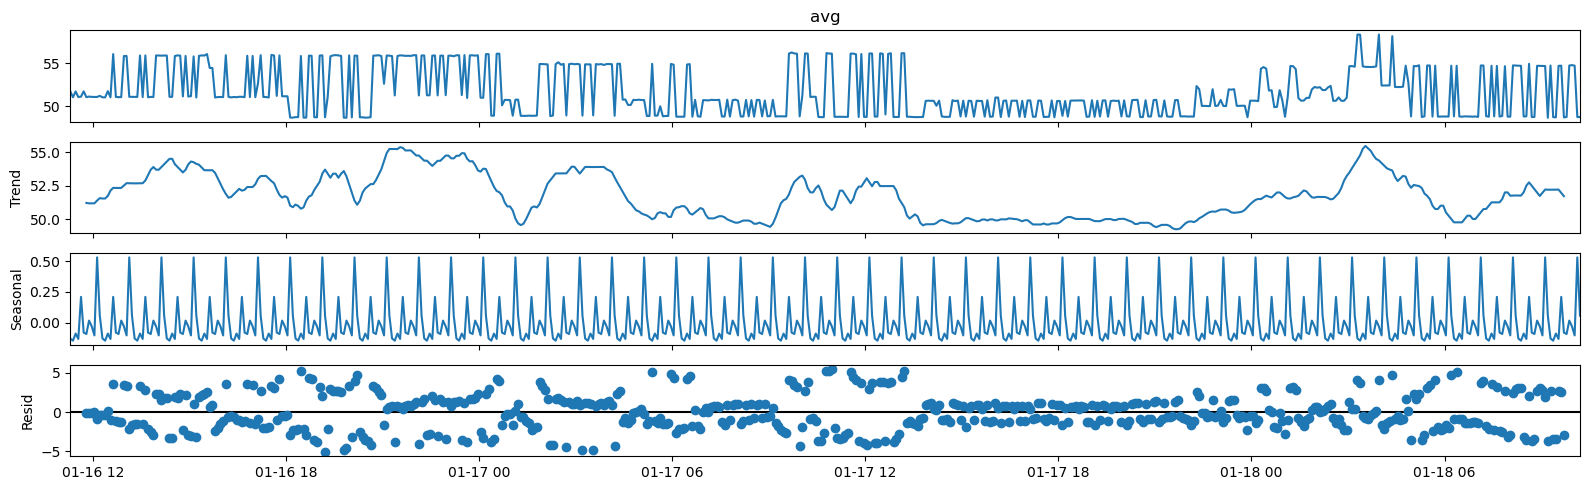

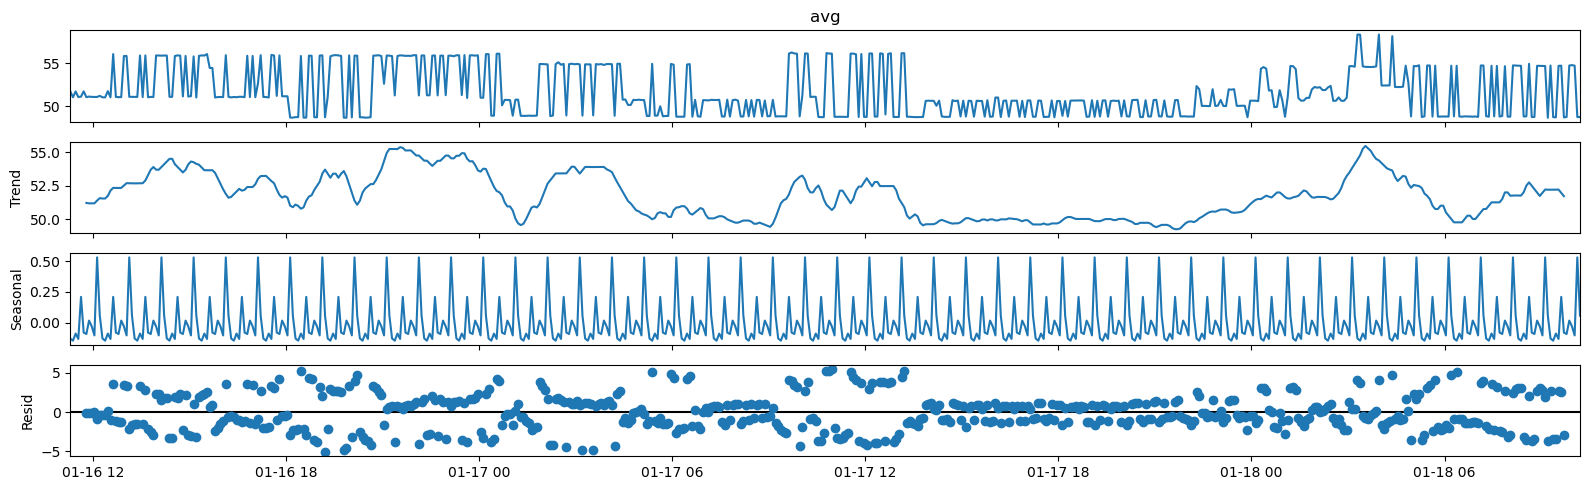

In [5]:
#seasonal decomposition forecasting model 
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_sktime['avg'],model ='additive',period=12)
result.plot()

In [6]:
# https://grisha.org/blog/2016/01/29/triple-exponential-smoothing-forecasting/
# given a series and alpha, return series of smoothed points

def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

results_1 = exponential_smoothing(df_sktime['avg'] , 0.2)
results_2 = exponential_smoothing(df_sktime['avg'] , 0.8)

C:\Users\anton\AppData\Local\Temp\ipykernel_27468\742746132.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result = [series[0]] # first value is same as series
C:\Users\anton\AppData\Local\Temp\ipykernel_27468\742746132.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  result.append(alpha * series[n] + (1 - alpha) * result[n-1])


In [7]:
df_sktime = df_sktime.assign(exsmooth1 = results_1)
df_sktime = df_sktime.assign(exsmooth2 = results_2)
df_sktime

,avg,exsmooth1,exsmooth2
new_time,,,
2023-01-16 11:17:39,51.726077,51.726077,51.726077
2023-01-16 11:22:39,51.025667,51.585995,51.165749
2023-01-16 11:27:39,51.706424,51.610081,51.598289
2023-01-16 11:32:39,51.052043,51.498473,51.161292
2023-01-16 11:37:39,51.100018,51.418782,51.112273
...,...,...,...
2023-01-18 09:52:39,54.746530,51.863391,53.584940
2023-01-18 09:57:39,54.792445,52.449202,54.550944
2023-01-18 10:02:39,54.728991,52.905160,54.693382


<Axes: xlabel='new_time'>

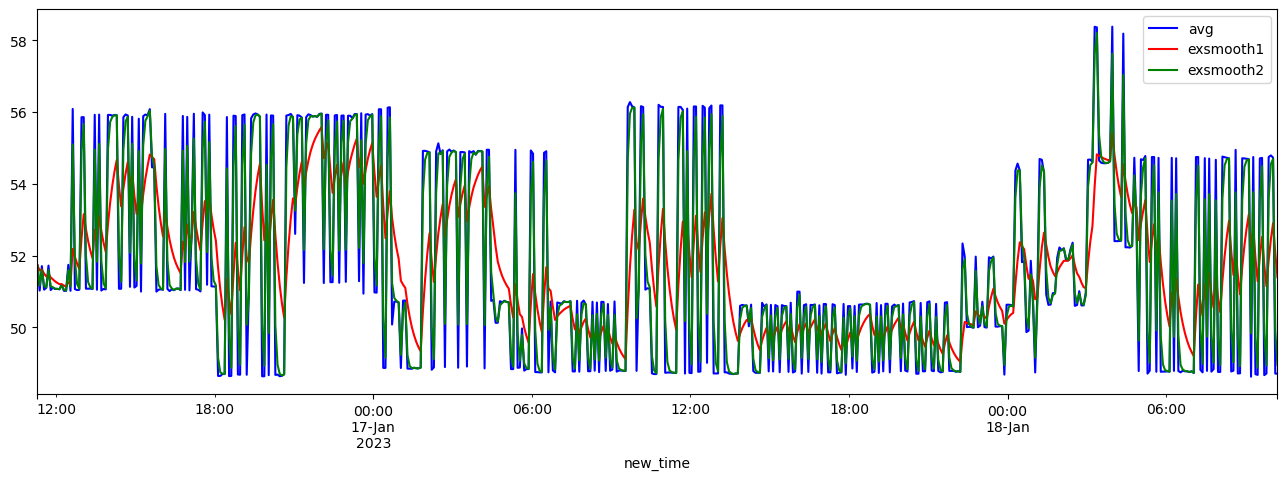

In [8]:
df_sktime['avg'].plot(color='blue', legend=True)
df_sktime['exsmooth1'].plot(color='red', legend=True)
df_sktime['exsmooth2'].plot(color='green', legend=True)

In [9]:
df_sse = df_sktime[df_sktime.index >= '2023-01-18']

se = (df_sse['exsmooth1']-df_sse['avg'])**2
se_exsmooth1 = se.mean()

se = (df_sse['exsmooth2']-df_sse['avg'])**2
se_exsmooth2 = se.mean()

print (se_exsmooth1 , se_exsmooth2)

4.561657054040217 0.37793038501477844


<AxesSubplot: xlabel='new_time'>

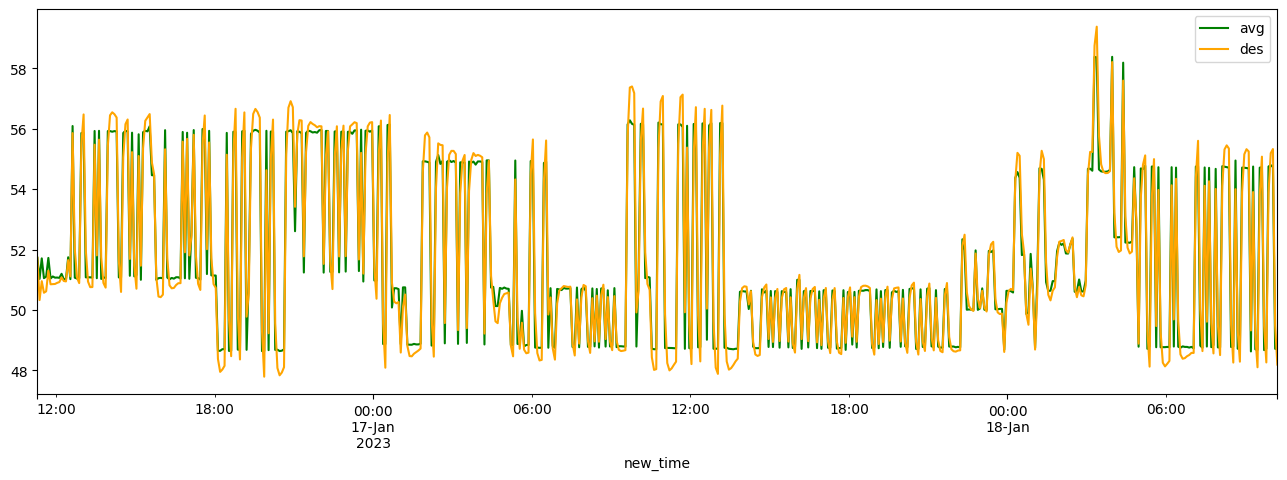

In [10]:
#https://grisha.org/blog/2016/02/16/triple-exponential-smoothing-forecasting-part-ii/
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # we are forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

results_1 = double_exponential_smoothing(df_sktime['avg'], alpha=0.8, beta=0.2)
df_sktime = df_sktime.assign(des = results_1[:-1])
df_sktime

#df_sktime = df_sktime.drop(columns=["exsmooth1","exsmooth2"])
df_sktime['avg'].plot(color='green',legend = True)
df_sktime['des'].plot(color='orange',legend = True)


In [11]:
df_dse = df_sktime[df_sktime.index >= '2023-01-18']
se = (df_dse['des']-df_dse['avg'])**2
se.mean()

0.28209083313185646

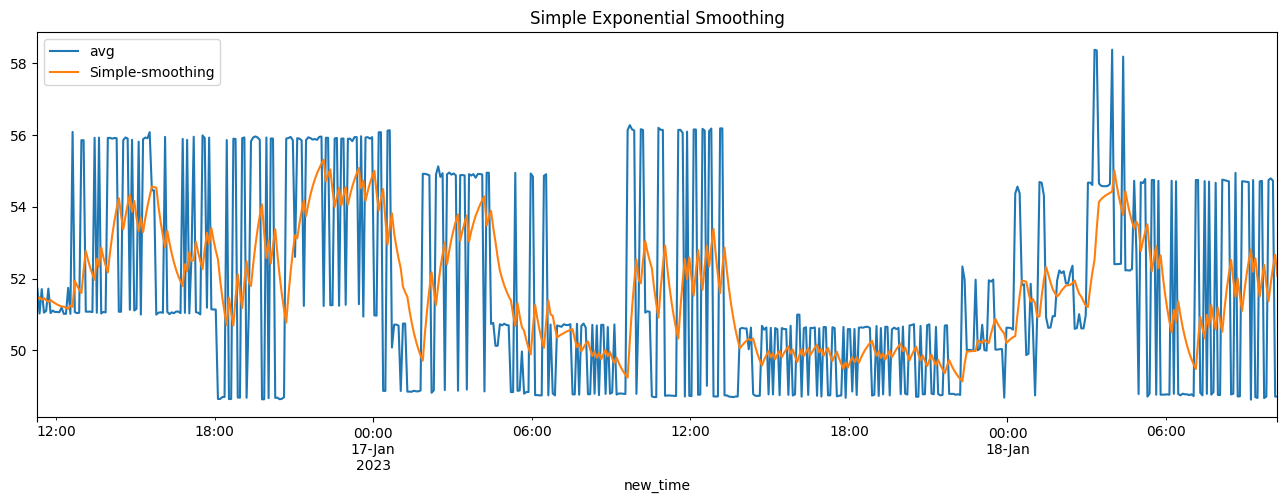

In [12]:
# Using the statsmodels tools 
# Simple Exponential Smoothing 

fit1 = SimpleExpSmoothing(df_sktime['avg']).fit()

df_sktime['Simple-smoothing'] = SimpleExpSmoothing(df_sktime['avg']).fit().fittedvalues
df_sktime[['avg','Simple-smoothing']].plot(title='Simple Exponential Smoothing');

In [13]:
df_sse = df_sktime[df_sktime.index >= '2023-01-18']
se = (df_sse['Simple-smoothing']-df_sse['avg'])**2
Statsmodels_sse = se.mean()
print(Statsmodels_sse)

7.078014568199791


/var/folders/fn/t1h5mchj4qg8nfdt2p1xfmwh0000gn/T/ipykernel_24612/626548833.py:4: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  df_sktime['Double-smoothing'] = Holt(df_sktime['avg']).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False).fittedvalues


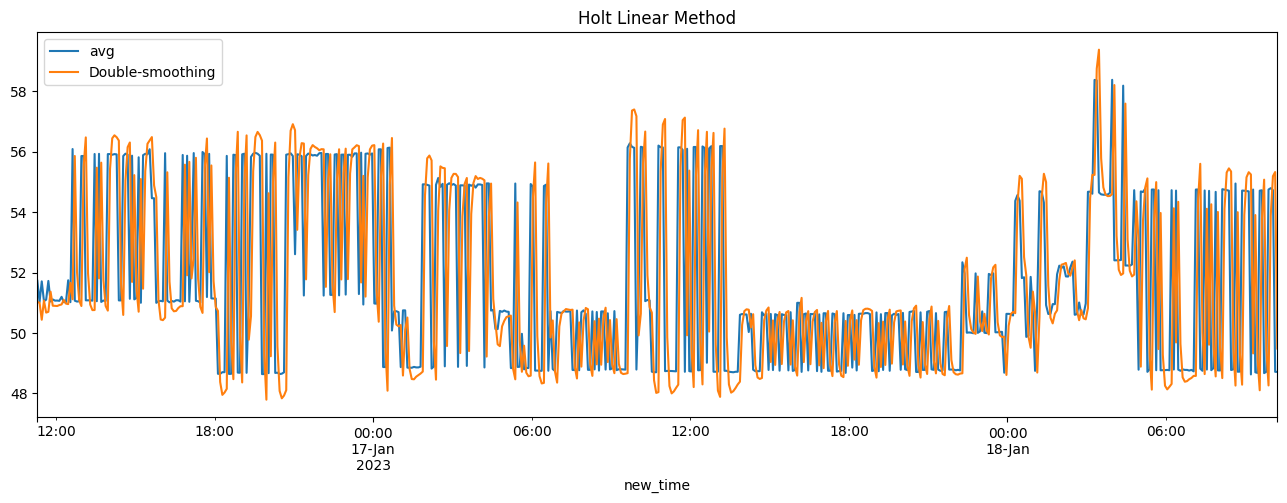

In [14]:
#Holts Linear method - Suitable for time series data with a trend component but without a seasonal component

fit2 = Holt(df_sktime['avg']).fit()
df_sktime['Double-smoothing'] = Holt(df_sktime['avg']).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False).fittedvalues
df_sktime[['avg','Double-smoothing']].plot(title='Holt Linear Method');

In [15]:
df_sse = df_sktime[df_sktime.index >= '2023-01-18']
se = (df_sse['Double-smoothing']-df_sse['avg'])**2
Statsmodels_dse  = se.mean()
print(Statsmodels_dse)

11.156263058289191


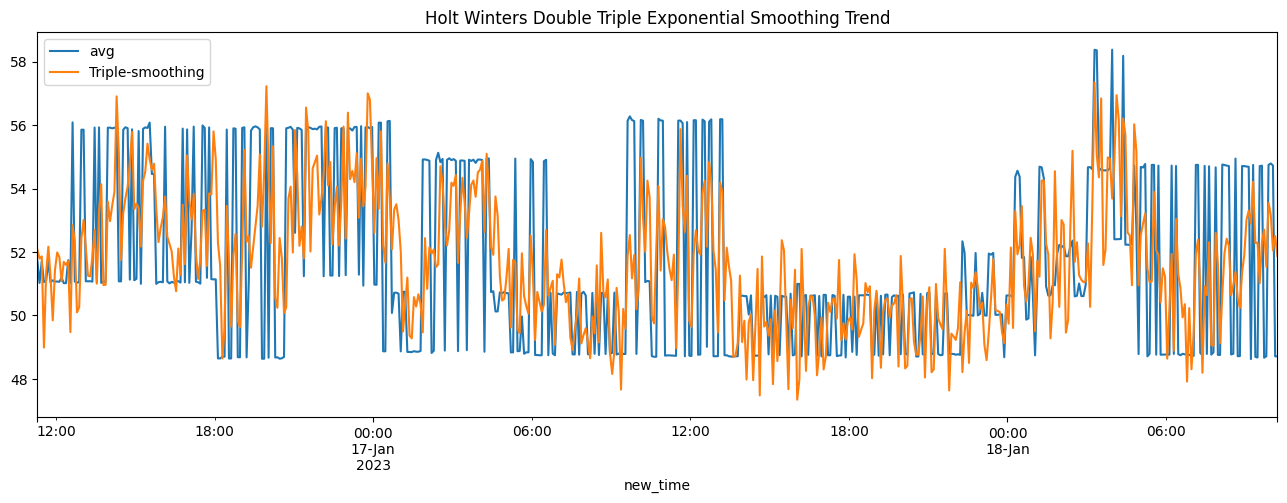

In [16]:
#Holt-Winters’ Seasonal Method - Suitable for time series data with trend and/or seasonal components
fit3 = ExponentialSmoothing(df_sktime['avg'],trend='add',seasonal='add',seasonal_periods=188).fit()
df_sktime['Triple-smoothing'] = ExponentialSmoothing(df_sktime['avg'],trend='add',seasonal='add',seasonal_periods=188).fit().fittedvalues
df_sktime[['avg','Triple-smoothing']].plot(title='Holt Winters Double Triple Exponential Smoothing Trend');

In [17]:
df_tse = df_sktime[df_sktime.index >= '2023-01-18']
se = (df_tse['Triple-smoothing']-df_tse['avg'])**2
Statsmodels_tse  = se.mean()
print(Statsmodels_tse)

4.9041759101609825


In [18]:
train = df_sktime.loc[df_sktime.index <= '2023-01-18']
test = df_sktime.loc[df_sktime.index >= '2023-01-18']

<AxesSubplot: xlabel='new_time'>

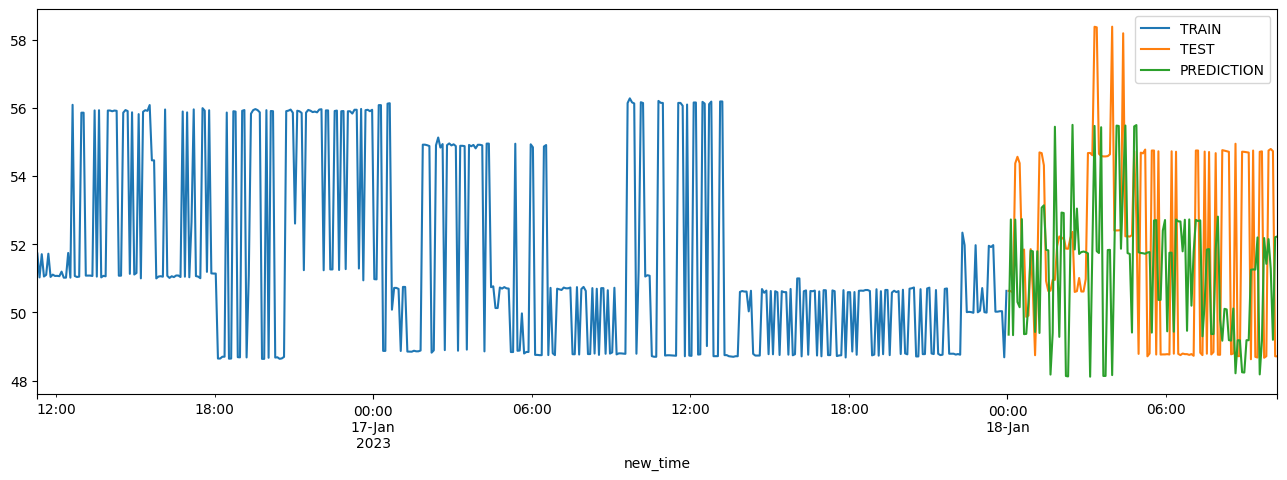

In [19]:
fitted_model = ExponentialSmoothing(train['avg'],trend='add',seasonal='add',seasonal_periods=188).fit()
test_predictions = fitted_model.forecast(123)

train['avg'].plot(legend=True,label='TRAIN')
test['avg'].plot(legend=True,label='TEST')
test_predictions.plot(legend=True,label= 'PREDICTION')

In [20]:
test['TTsplit'] = test_predictions.values
se = (test['TTsplit']-test['avg'])**2
Statsmodels_tts = se.mean()
print(Statsmodels_tts)

11.494910115230555


/var/folders/fn/t1h5mchj4qg8nfdt2p1xfmwh0000gn/T/ipykernel_24612/968391733.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['TTsplit'] = test_predictions.values


In [21]:
test

,avg,exsmooth1,exsmooth2,des,Simple-smoothing,Double-smoothing,Triple-smoothing,TTsplit
new_time,,,,,,,,
2023-01-18 00:02:39,50.630757,50.292633,50.563663,50.625476,50.269134,50.236797,49.741336,49.346865
2023-01-18 00:07:39,50.622346,50.358576,50.610610,50.695983,50.322960,50.625476,52.141480,52.724799
2023-01-18 00:12:39,50.576749,50.402210,50.583521,50.654529,50.367523,50.695983,49.606298,49.332012
2023-01-18 00:17:39,54.370250,51.195818,53.612904,54.275555,50.398665,50.654529,53.294468,52.720578
2023-01-18 00:22:39,54.563369,51.869328,54.373276,55.200305,50.989821,54.275555,51.929416,50.303076
...,...,...,...,...,...,...,...,...
2023-01-18 09:52:39,54.746530,51.863391,53.584940,53.882798,51.367933,48.260925,53.548033,52.148553
2023-01-18 09:57:39,54.792445,52.449202,54.550944,55.189447,51.870824,53.882798,53.187627,51.279805
2023-01-18 10:02:39,54.728991,52.905160,54.693382,55.326341,52.305697,55.189447,52.049837,49.196096


In [22]:
df_sktime

,avg,exsmooth1,exsmooth2,des,Simple-smoothing,Double-smoothing,Triple-smoothing
new_time,,,,,,,
2023-01-16 11:17:39,51.726077,51.726077,51.726077,51.726077,51.434405,51.025667,52.075989
2023-01-16 11:22:39,51.025667,51.585995,51.165749,50.325258,51.477820,50.997651,51.794090
2023-01-16 11:27:39,51.706424,51.610081,51.598289,50.950767,51.410519,50.436203,51.863375
2023-01-16 11:32:39,51.052043,51.498473,51.161292,50.568569,51.454563,51.071753,48.988579
2023-01-16 11:37:39,51.100018,51.418782,51.112273,50.615541,51.394649,50.672205,51.366450
...,...,...,...,...,...,...,...
2023-01-18 09:52:39,54.746530,51.863391,53.584940,53.882798,51.367933,48.260925,53.548033
2023-01-18 09:57:39,54.792445,52.449202,54.550944,55.189447,51.870824,53.882798,53.187627
2023-01-18 10:02:39,54.728991,52.905160,54.693382,55.326341,52.305697,55.189447,52.049837
